In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

In [2]:
normal_video_directory = './videos/Normal videos'
anomaly_video_directory = './videos/Anomaly Videos'

In [3]:
def convert_to_gray(img):
    converted_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )
    return converted_gray

In [4]:
def resize_frame(frame):
    resized_image = cv2.resize(frame, (256, 256))
    return resized_image

In [5]:
def normalize_frame(frame):
    normalized_frame = np.divide(frame, 255.0).astype(np.float32) 
    return normalized_frame

In [6]:
def perform_frame_preprocessing(frame):
    
    resized_image = resize_frame(frame)
    gray_converted = convert_to_gray(resized_image)
    normalized_image = normalize_frame(gray_converted)
    normalized_image = np.expand_dims(normalized_image, axis=-1)
    return normalized_image

In [7]:
all_frames = []

In [8]:
files_in_directory = os.listdir(normal_video_directory)
sequence_length = 10

count = 0
for file in tqdm(files_in_directory):
    
    file_path = os.path.join(normal_video_directory, file)
    count += 1
    # if count == 21:
    #     break
    if str(file_path)[-3:] == "mp4":
        
        video_file = cv2.VideoCapture(file_path)
        video_frames = []
        while True:
            ret, frame = video_file.read()

            #If the end of frames or any error in reading
            if not ret:
                break

            frame = perform_frame_preprocessing(frame)
            video_frames.append(frame)
        
        video_file.release()
        cv2.destroyAllWindows()
        
        frames_length = len(video_frames)
        num_sequences = frames_length // sequence_length
        video_frames = video_frames[:num_sequences * sequence_length]
        all_frames.extend(video_frames)
        video_frames = []

        

  0%|          | 0/26 [00:00<?, ?it/s]

In [9]:
len(all_frames)

66030

In [10]:
all_frames[0].shape

(256, 256, 1)

In [11]:
type(all_frames)

list

In [48]:
# import pickle

# # Save the dataset to a file
# with open('all_frames_.pkl', 'wb') as f:
#     pickle.dump(all_frames, f)

In [113]:
# import pickle
# with open('mgfn_ucf.pkl', 'rb') as f:
#     try_model = pickle.load(f)

In [12]:
type(all_frames)

list

In [13]:
def get_dataset_in_sequences():
    #defining the frame list and a sequence length
    frames_list = all_frames
    sequence_length = 10
    
    clips = []
    size = len(frames_list)
    
    for i in range(0, size, sequence_length):
        sequence_frames = frames_list[i : i + sequence_length]
        
        if len(sequence_frames) == sequence_length:
            clip = np.zeros(shape=(sequence_length, 256, 256, 1))
            for j in range(sequence_length):
                frame = sequence_frames[j]
                clip[j] = frame
            
            yield clip, clip
            
    
    
    

In [18]:
# #Defining the generator
# frames_generator = get_dataset_in_sequences()

In [19]:
# def count_sequences(generator_func):
#     count = 0
#     for _ in generator_func:
#         count += 1
#     return count

# num_sequences = count_sequences(frames_generator)
# print(f"Number of sequences produced by the generator: {num_sequences}")


Number of sequences produced by the generator: 6603


In [28]:
# for frame in frames_generator:
#     print(frame.shape)
#     break

In [14]:
#output shape and data type of the dataset
output_signature = (tf.TensorSpec(shape=(10, 256, 256, 1), dtype=tf.float32),
                    tf.TensorSpec(shape=(10, 256, 256, 1), dtype=tf.float32))

# Converting the generator into a tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    get_dataset_in_sequences,
    output_signature = output_signature
)

batch_size = 4 
dataset = dataset.batch(batch_size).repeat().prefetch(tf.data.experimental.AUTOTUNE)


2023-08-03 11:34:05.557249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9798 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [15]:
pre_trained_model = tf.keras.models.load_model('./model.hdf5')

In [16]:
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDi  (None, 10, 64, 64, 128)   15616     
 stributed)                                                      
                                                                 
 layer_normalization_1 (Lay  (None, 10, 64, 64, 128)   256       
 erNormalization)                                                
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 32, 32, 64)    204864    
 stributed)                                                      
                                                                 
 layer_normalization_2 (Lay  (None, 10, 32, 32, 64)    128       
 erNormalization)                                                
                                                                 
 conv_lst_m2d_1 (ConvLSTM2D  (None, 10, 32, 32, 64)   

In [26]:
print(pre_trained_model.layers[:8])

[<keras.src.layers.rnn.time_distributed.TimeDistributed object at 0x7fa1c8706d30>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7fa1c86975b0>, <keras.src.layers.rnn.time_distributed.TimeDistributed object at 0x7fa1c863f4f0>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7fa1c8674430>, <keras.src.layers.rnn.conv_lstm2d.ConvLSTM2D object at 0x7fa1c8674730>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7fa1c8674c10>, <keras.src.layers.rnn.conv_lstm2d.ConvLSTM2D object at 0x7fa1c8674af0>, <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7fa1c8582ca0>]


In [25]:
pre_trained_model.layers[5]

In [27]:
for layer in pre_trained_model.layers[:8]: 
    layer.trainable = False

# Unfreezing the final the layers (TimeDistributed with Conv2DTranspose and Conv2D)
for layer in pre_trained_model.layers[8:]:
    layer.trainable = True

In [28]:
# pre_trained_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

pre_trained_model.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6), metrics = ['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('loss') <= 0.0014):
            print('\nLoss fell down 0.01, Stopping Training!')
            self.model.stop_training = True

In [30]:
callback = myCallback()

In [31]:
history = pre_trained_model.fit(
    dataset,
    epochs = 12,
    callbacks = [callback],
    steps_per_epoch = 1650,
    shuffle = False
)

Epoch 1/12


2023-08-03 11:48:22.439544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-03 11:48:22.507895: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1650/1650 [==============================] - 1530s 911ms/step - loss: 0.0054 - accuracy: 0.1841
Epoch 2/12
1650/1650 [==============================] - 1706s 1s/step - loss: 0.0042 - accuracy: 0.1841
Epoch 3/12
1650/1650 [==============================] - 1807s 1s/step - loss: 0.0039 - accuracy: 0.1841
Epoch 4/12
1650/1650 [==============================] - 1991s 1s/step - loss: 0.0036 - accuracy: 0.1841
Epoch 5/12
1650/1650 [==============================] - 1995s 1s/step - loss: 0.0034 - accuracy: 0.1841
Epoch 6/12
1650/1650 [==============================] - 2002s 1s/step - loss: 0.0033 - accuracy: 0.1841
Epoch 7/12
1650/1650 [==============================] - 1990s 1s/step - loss: 0.0032 - accuracy: 0.1841
Epoch 8/12
1650/1650 [==============================] - 2010s 1s/step - loss: 0.0031 - accuracy: 0.1841
Epoch 9/12
1650/1650 [==============================] - 2001s 1s/step - loss: 0.0030 - accuracy: 0.1841
Epoch 10/12
1650/1650 [==============================] - 1997s 1s/step -

In [32]:
pre_trained_model.save('./auto_encoder3.hdf5')

/usr/local/lib/python3.9/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Testing

In [33]:
import random

In [34]:
files_in_normal_directory = os.listdir(normal_video_directory)
files_in_anomaly_directory = os.listdir(anomaly_video_directory)
normal_video_file = random.choice(files_in_normal_directory)
anomaly_video_file = random.choice(files_in_anomaly_directory)

print(normal_video_file,anomaly_video_file)

normal_video_file_path = os.path.join(normal_video_directory, normal_video_file)
anomaly_video_file_path = os.path.join(anomaly_video_directory, anomaly_video_file)

Normal_Videos_312_x264.mp4 Arson002_x264.mp4


In [85]:
test_frame_list = []

In [86]:
video_file = cv2.VideoCapture(anomaly_video_file_path)
video_frames = []
frame_count = 0
while True:
    ret, frame = video_file.read()

    #If the end of frames or any error in reading
    if not ret:
        break

    frame = perform_frame_preprocessing(frame)
    frame_count += 1
    test_frame_list.append(frame)
    
    if frame_count == 10:
        break


video_file.release()
cv2.destroyAllWindows()

In [87]:
def display_image(image):
    plt.imshow(image)
    plt.show()

In [88]:
def get_frames_from_video(video_file_path):
    video_file = cv2.VideoCapture(video_file_path)
    
    total_frames = 0
    original_frames_dict = {}
    
    while True:
        ret, frame = video_file.read()

        #If the end of frames or any error in reading
        if not ret:
            break
            
        total_frames += 1

        original_frames_dict[total_frames] = frame
    
    video_file.release()
    cv2.destroyAllWindows()
    
    return original_frames_dict

In [94]:
frames_dict = get_frames_from_video(anomaly_video_file_path)
len(frames_dict)

4439

In [95]:
def get_frames_in_batches(batch_size, frames_dict):
    count = 0
    frames_in_batch_size = []
    all_frames_list = []
    
    for i in range(1, len(frames_dict) + 1):
        count += 1
        frame = frames_dict[i]
        preprocessed_frame = perform_frame_preprocessing(frame)
        frames_in_batch_size.append(preprocessed_frame)
        
        if count == batch_size:
            count = 0
            all_frames_list.extend(frames_in_batch_size)
            frames_in_batch_size = []
            
    all_frames_array = np.array(all_frames_list)
    num_batches = all_frames_array.shape[0] // batch_size
    all_frames_in_batches = all_frames_array.reshape((num_batches, batch_size, 256, 256, 1))
    
    return all_frames_in_batches


In [96]:
all_frames_in_batches = get_frames_in_batches(10, frames_dict)

In [97]:
all_frames_in_batches.shape

(443, 10, 256, 256, 1)

In [98]:
len(all_frames_in_batches)

443

In [59]:
reconstructed_frames = []
for count, frame_batch in enumerate(all_frames_in_batches):
    frame_batch = frame_batch.reshape((1, 10, 256, 256, 1))
    reconstructed_frame = pre_trained_model.predict(frame_batch)
    reconstructed_frames.append(reconstructed_frame)
    print(f'Done {count + 1}')

1/1 [==============================] - 0s 29ms/step
Done 1
1/1 [==============================] - 0s 31ms/step
Done 2
1/1 [==============================] - 0s 28ms/step
Done 3
1/1 [==============================] - 0s 28ms/step
Done 4
1/1 [==============================] - 0s 28ms/step
Done 5
1/1 [==============================] - 0s 32ms/step
Done 6
1/1 [==============================] - 0s 27ms/step
Done 7
1/1 [==============================] - 0s 28ms/step
Done 8
1/1 [==============================] - 0s 28ms/step
Done 9
1/1 [==============================] - 0s 27ms/step
Done 10
1/1 [==============================] - 0s 30ms/step
Done 11
1/1 [==============================] - 0s 27ms/step
Done 12
1/1 [==============================] - 0s 28ms/step
Done 13
1/1 [==============================] - 0s 28ms/step
Done 14
1/1 [==============================] - 0s 28ms/step
Done 15
1/1 [==============================] - 0s 29ms/step
Done 16
1/1 [==============================] - 0s 27ms/st

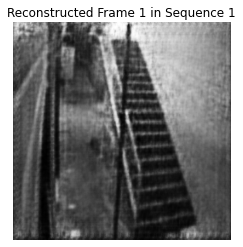

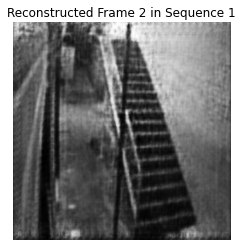

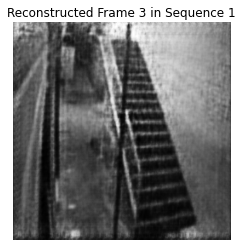

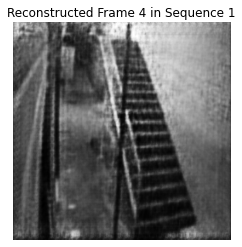

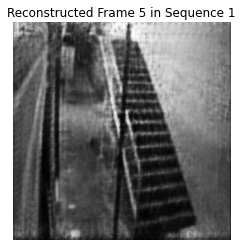

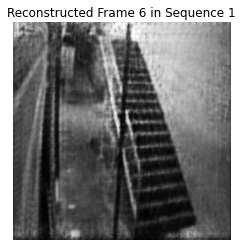

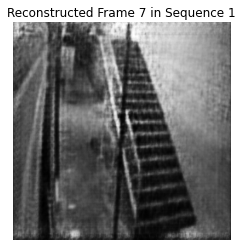

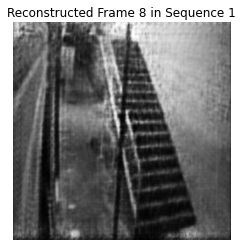

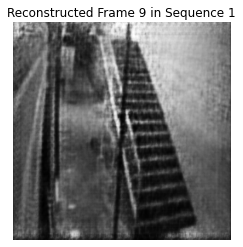

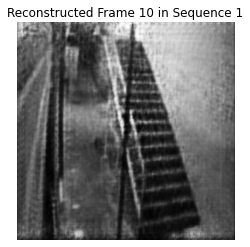

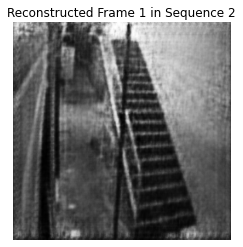

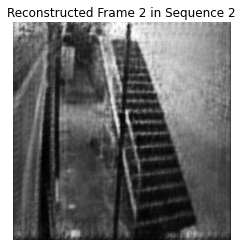

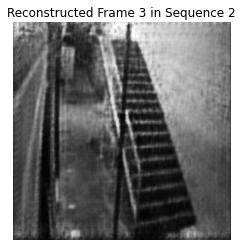

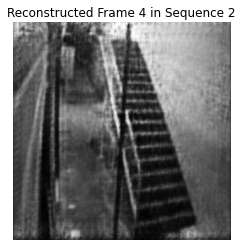

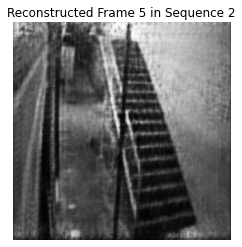

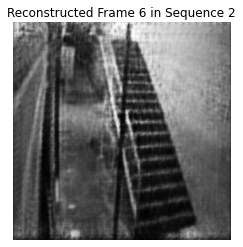

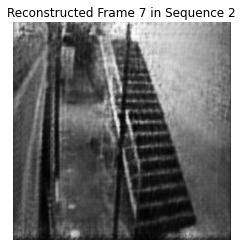

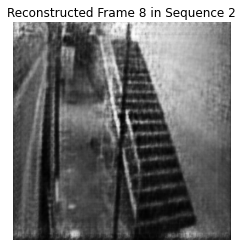

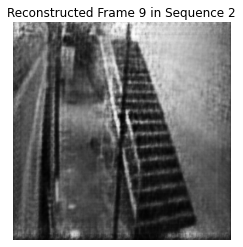

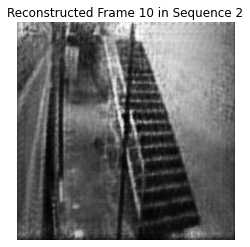

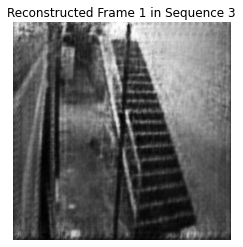

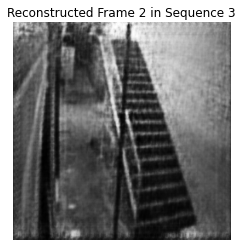

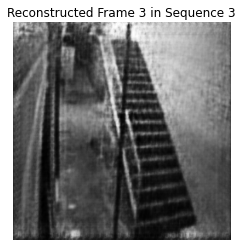

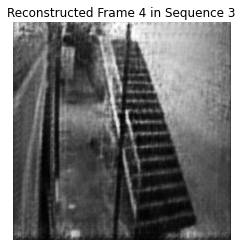

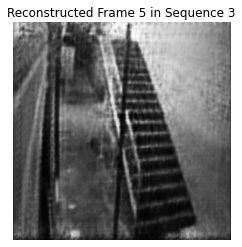

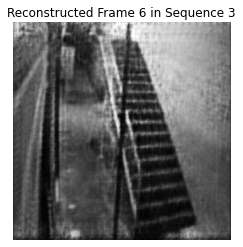

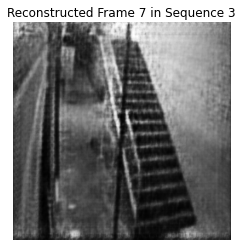

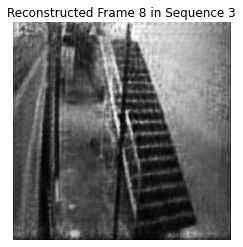

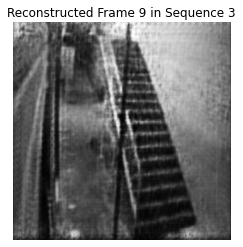

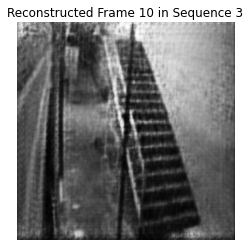

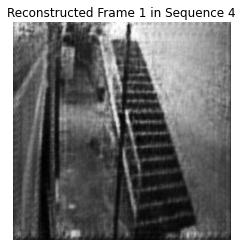

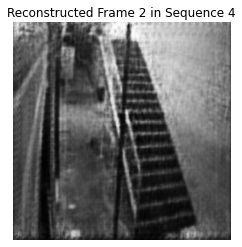

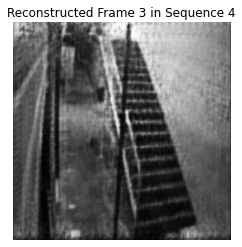

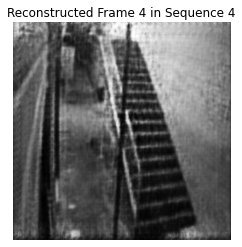

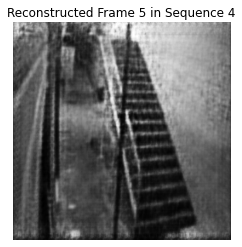

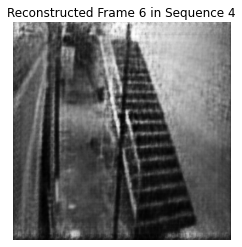

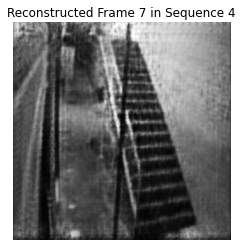

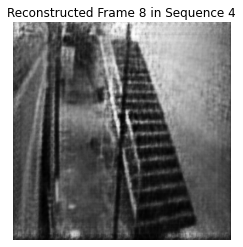

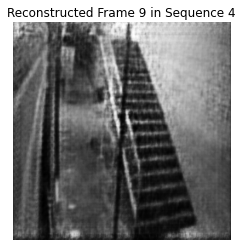

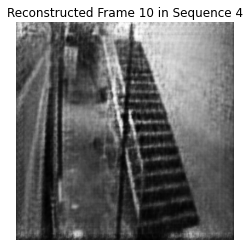

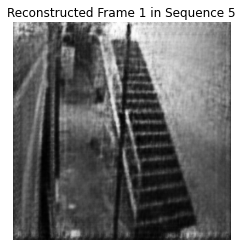

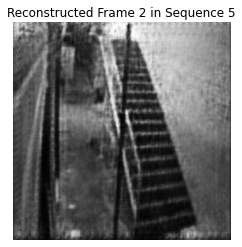

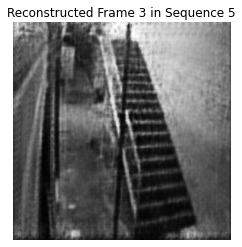

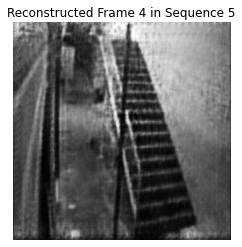

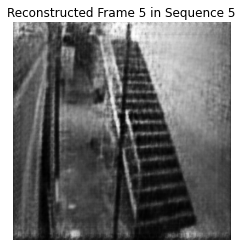

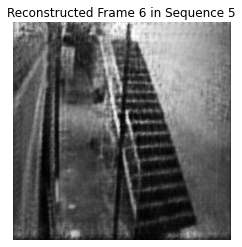

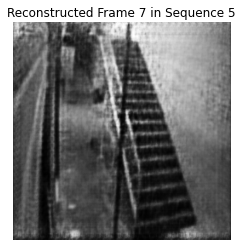

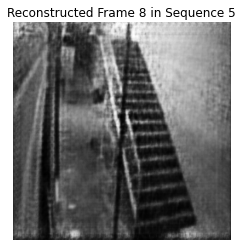

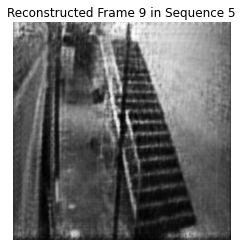

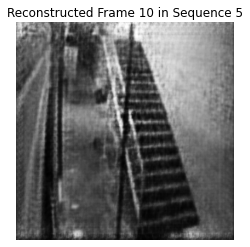

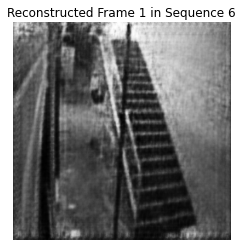

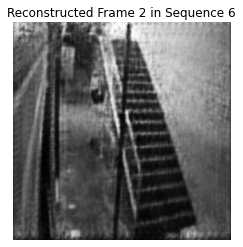

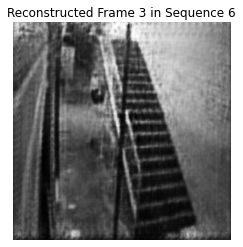

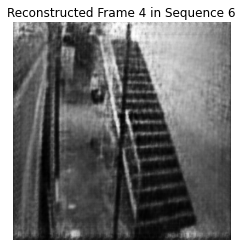

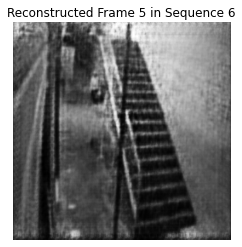

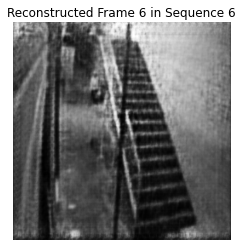

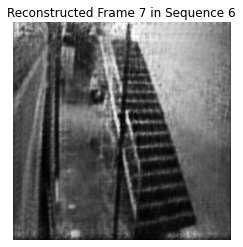

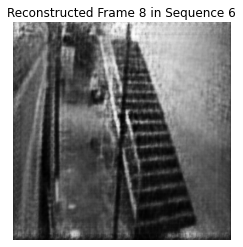

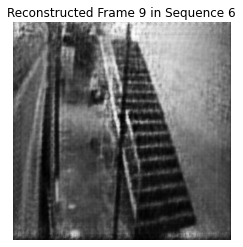

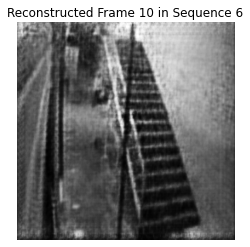

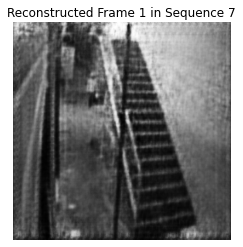

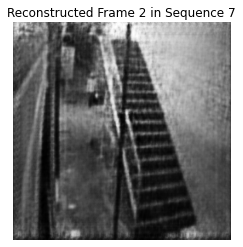

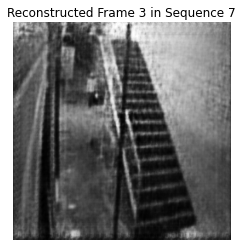

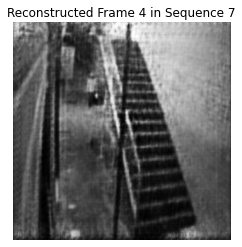

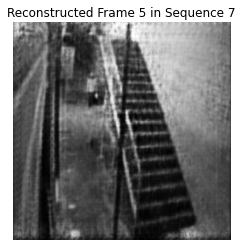

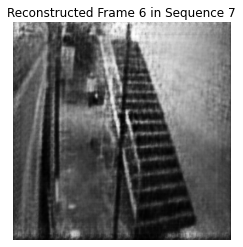

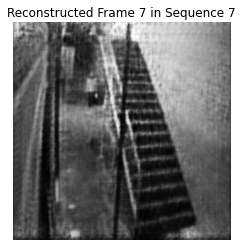

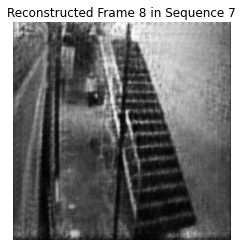

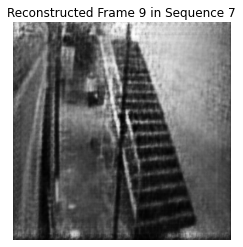

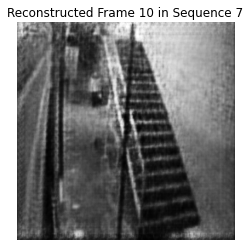

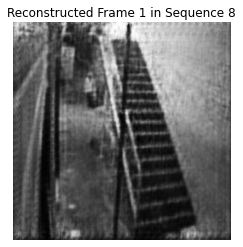

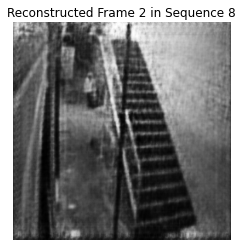

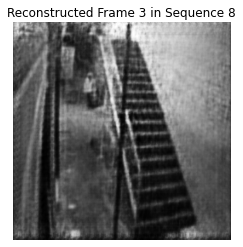

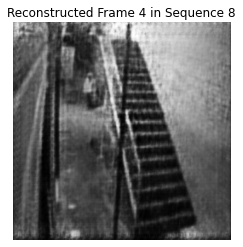

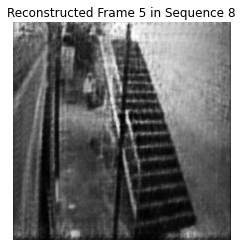

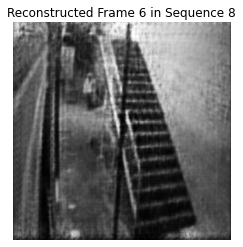

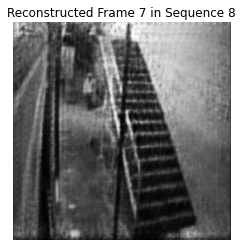

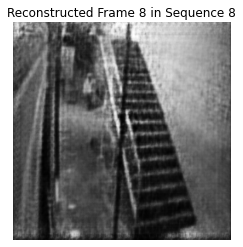

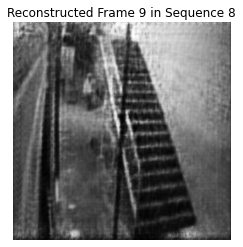

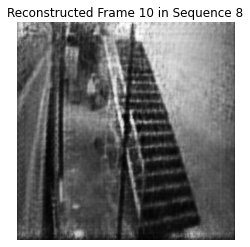

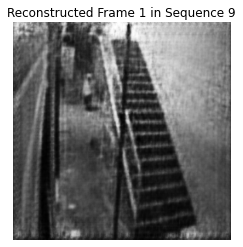

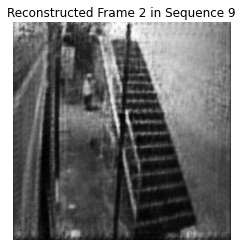

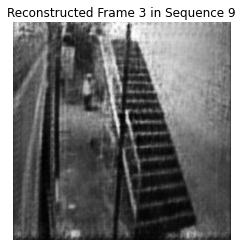

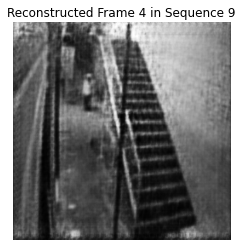

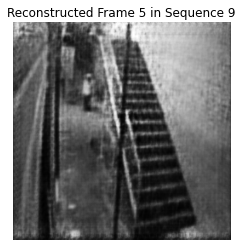

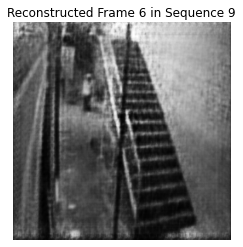

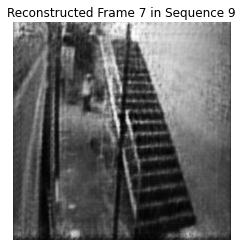

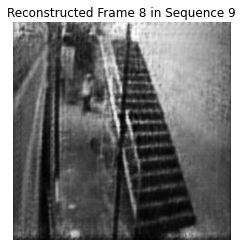

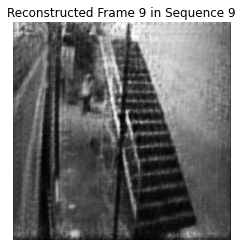

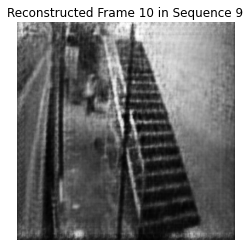

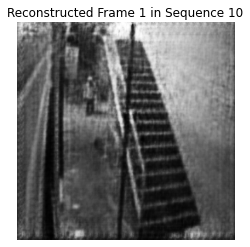

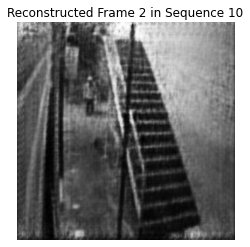

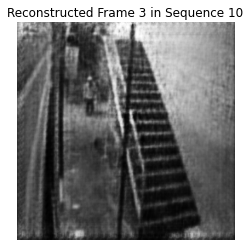

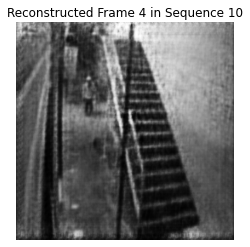

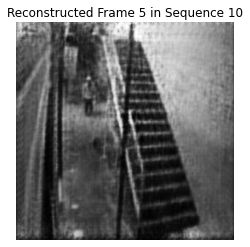

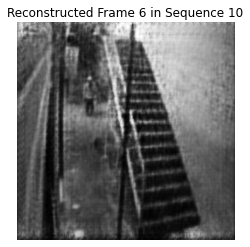

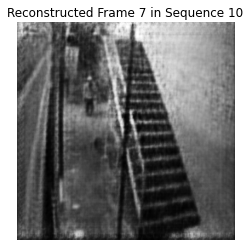

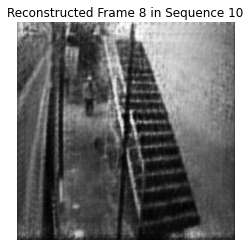

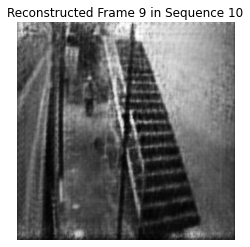

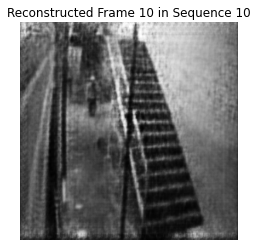

In [60]:
for i in range(10):
    predicted_sequence = reconstructed_frames[i][0]  # Extract the predicted sequence
    for j in range(10):
        reconstructed_frame = predicted_sequence[j, :, :, 0]
        plt.imshow(reconstructed_frame, cmap='gray')
        plt.title(f'Reconstructed Frame {j + 1} in Sequence {i + 1}')
        plt.axis('off')
        plt.show()

In [109]:
new_test_list = []
for entry in reconstructed_frames:
    entry.reshape(10,256,256,1)
    new_test_list.append(entry)

In [152]:
print(reconstructed_frames[0].shape)

(1, 10, 256, 256, 1)


In [139]:
len(new_test_list)

100

100


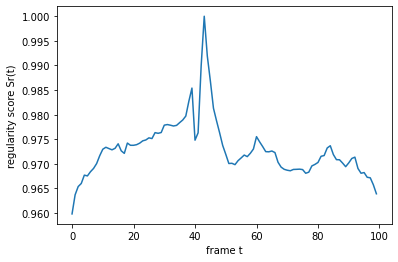

In [142]:
sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(all_frames_in_batches[i],new_test_list[i])) for i in range(0,100)])
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
print(len(sa))
sr = 1.0 - sa

# plot the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()

In [147]:
to_show = frames_dict[100]

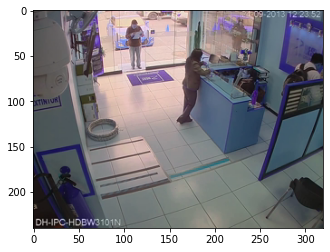

In [148]:
display_image(to_show)

In [170]:
print(all_frames_in_batches[442].shape)

(10, 256, 256, 1)


1/1 [==============================] - 0s 28ms/step
Done 0
1/1 [==============================] - 0s 27ms/step
Done 1
1/1 [==============================] - 0s 27ms/step
Done 2
1/1 [==============================] - 0s 27ms/step
Done 3
1/1 [==============================] - 0s 26ms/step
Done 4
1/1 [==============================] - 0s 27ms/step
Done 5
1/1 [==============================] - 0s 26ms/step
Done 6
1/1 [==============================] - 0s 27ms/step
Done 7
1/1 [==============================] - 0s 27ms/step
Done 8
1/1 [==============================] - 0s 27ms/step
Done 9
1/1 [==============================] - 0s 26ms/step
Done 10
1/1 [==============================] - 0s 26ms/step
Done 11
1/1 [==============================] - 0s 26ms/step
Done 12
1/1 [==============================] - 0s 26ms/step
Done 13
1/1 [==============================] - 0s 26ms/step
Done 14
1/1 [==============================] - 0s 27ms/step
Done 15
1/1 [==============================] - 0s 26ms/ste

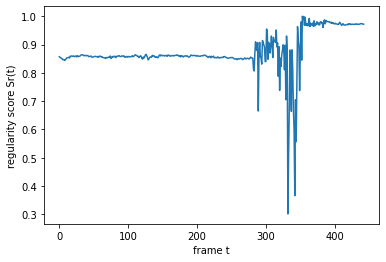

In [99]:
reconstruction_costs = []

# Iterating over each sequence and predicting
for count, seq in enumerate(all_frames_in_batches):
    # Reshaping to have the appropriate input shape for the model
    single_sequence = np.expand_dims(seq, axis=0)
    
    # Prediction using the model
    reconstructed_sequence = pre_trained_model.predict(single_sequence)
    print(f'Done {count}')
    
    # Calculating reconstruction cost for the single sequence
    cost = np.linalg.norm(seq - reconstructed_sequence[0])
    
    # Appending the cost to list
    reconstruction_costs.append(cost)

# Converting to numpy array for further processing
sequences_reconstruction_cost = np.array(reconstruction_costs)

# Normalizing the reconstruction costs according to the paper
sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
sr = 1.0 - sa

# Plotting the regularity scores
plt.plot(sr)
plt.ylabel('regularity score Sr(t)')
plt.xlabel('frame t')
plt.show()


In [40]:
len(reconstruction_costs)

443

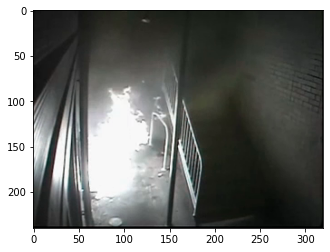

In [41]:
display_image(frames_dict[3050])

In [121]:
seq_to_display = all_frames_in_batches[400]

In [122]:
len(seq_to_display)

10

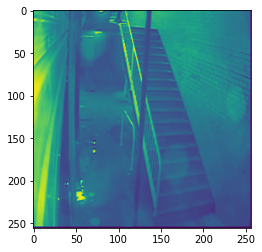

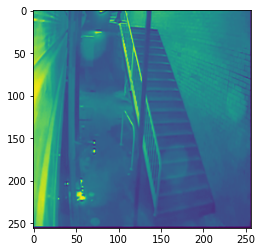

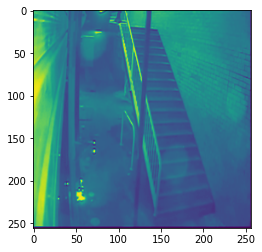

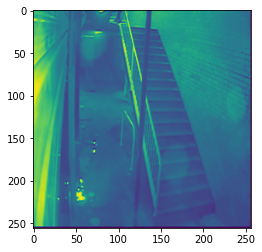

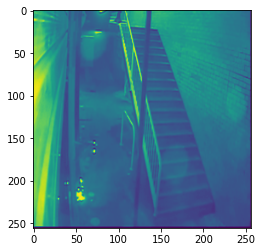

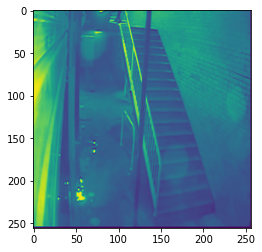

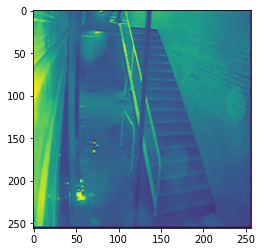

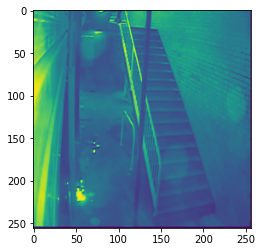

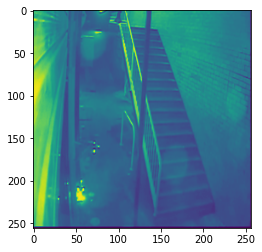

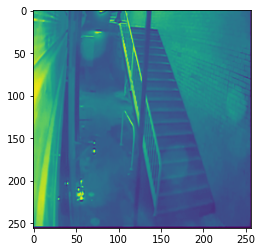

In [123]:
for seq in seq_to_display:
    display_image(seq)